In [1]:
%matplotlib inline


# Hubble

Aligning HST images with JHAT.


An example HST Dataset is downloaded, and then a series of
alignment methods are used. For more information on the
key parameters used for alignment see 
`params:Useful Parameters`.



In [2]:
import sys,os,glob
from astropy.io import fits
from astropy.table import Table
from astropy.nddata import extract_array
from astropy.coordinates import SkyCoord
from astropy import wcs
from astropy.wcs.utils import skycoord_to_pixel
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from astroquery.mast import Observations
from astropy.visualization import (simple_norm,LinearStretch)

import jhat
from jhat import hst_photclass,st_wcs_align



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


## Relative Alignment

**Download some Data**

For this example we download 2 HST DRZ images from MAST. They're
the same filter and same field, just separated in time. 



In [3]:
obs_table = Observations.query_criteria(obs_id='hst_16264_12_wfc3_ir_f110w_iebc12')
obs_table1 = obs_table[obs_table['filters']=='F110W']

obs_table = Observations.query_criteria(obs_id='hst_16264_15_wfc3_ir_f110w_iebc15')
obs_table2 = obs_table[obs_table['filters']=='F110W']

data_products_by_obs = Observations.get_product_list(obs_table1)
data_products_by_obs = data_products_by_obs[data_products_by_obs['calib_level']==3]
data_products_by_obs = data_products_by_obs[data_products_by_obs['productSubGroupDescription']=='DRZ'][0]
Observations.download_products(data_products_by_obs,extension='fits')

data_products_by_obs = Observations.get_product_list(obs_table2)
data_products_by_obs = data_products_by_obs[data_products_by_obs['calib_level']==3]
data_products_by_obs = data_products_by_obs[data_products_by_obs['productSubGroupDescription']=='DRZ'][0]
Observations.download_products(data_products_by_obs,extension='fits')

Local Path,Status,Message,URL
str95,str8,object,object
./mastDownload/HST/hst_16264_15_wfc3_ir_f110w_iebc15/hst_16264_15_wfc3_ir_f110w_iebc15_drz.fits,COMPLETE,None,None


**Examine the Reference Image**




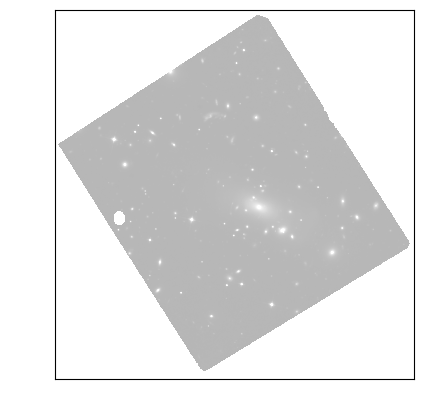

In [4]:
files = glob.glob('mastDownload/HST/*/*drz.fits')
ref_image = files[0]
ref_fits = fits.open(ref_image)
ref_data = fits.open(ref_image)['SCI',1].data
norm1 = simple_norm(ref_data,stretch='log',min_cut=-1,max_cut=15)

plt.imshow(ref_data, origin='lower',
                      norm=norm1,cmap='gray')
plt.gca().tick_params(labelcolor='none',axis='both',color='none')
plt.show()

**Zoom in to see the offset**

Here add an artificial offset to the wcs, and then we see the 
same star in both images at the same ra/dec
location, demonstrating a large offset between
the images.  



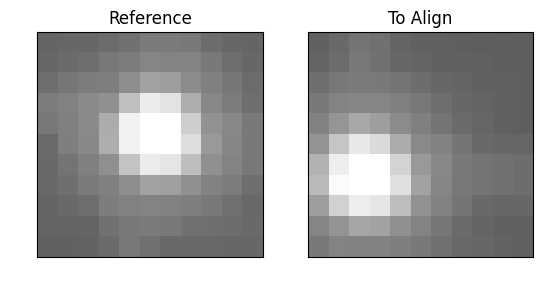

In [5]:
star_location = SkyCoord('21:29:40.5351','+0:04:42.697',unit=(u.hourangle,u.deg))
align_image = files[1]
align_fits = fits.open(align_image)
align_fits['SCI',1].header['CRPIX1']+=2
align_fits['SCI',1].header['CRPIX2']+=2
align_fits.writeto(align_image,overwrite=True)

align_data = fits.open(align_image)['SCI',1].data
ref_y,ref_x = skycoord_to_pixel(star_location,wcs.WCS(ref_fits['SCI',1],ref_fits))
align_y,align_x = skycoord_to_pixel(star_location,wcs.WCS(align_fits['SCI',1],align_fits))

ref_cutout = extract_array(ref_data,(11,11),(ref_x,ref_y))
align_cutout = extract_array(align_data,(11,11),(align_x,align_y))
norm1 = simple_norm(ref_cutout,stretch='log',min_cut=-1,max_cut=200)
norm2 = simple_norm(align_cutout,stretch='log',min_cut=-1,max_cut=200)
fig,axes = plt.subplots(1,2)
axes[0].imshow(ref_cutout, origin='lower',
                      norm=norm1,cmap='gray')
axes[1].imshow(align_cutout, origin='lower',
                      norm=norm2,cmap='gray')
axes[0].set_title('Reference')
axes[1].set_title('To Align')
axes[0].tick_params(labelcolor='none',axis='both',color='none')
axes[1].tick_params(labelcolor='none',axis='both',color='none')

plt.show()

**Create a Photometric Catalog for Relative Alignment**

We choose one of the images to be the reference image, and then 
create a catalog that we will use to align the other image.



In [6]:
hst_phot = hst_photclass(psf_fwhm=1.8,aperture_radius=5)
hst_phot.run_phot(imagename=ref_image,photfilename='auto',overwrite=True)
ref_catname = ref_image.replace('.fits','.phot.txt') # the default
refcat = Table.read(ref_catname,format='ascii')
print(refcat)

aper_sum_5.0px annulus_median_5.0px aper_bkg_5.0px aper_sum_bkgsub_5.0px flux_err_5.0px    mag      dmag       x           y      sharpness roundness1 roundness2     ra       dec      x_idl     y_idl   
-------------- -------------------- -------------- --------------------- -------------- --------- -------- ---------- ----------- --------- ---------- ---------- ---------- -------- --------- ----------
     98.701667             1.222411       96.00792              3.014762       0.532717 25.620868 0.176667 637.771565   68.896517  0.652855   0.761563   0.643213  322.42209  0.06782   10.2829 -58.751291
    112.858706             1.215698       95.48066             19.448989       0.526919 23.596757 0.029024 561.750751   84.358198  0.739666  -0.792056   0.727787 322.424799 0.068371  0.099716 -56.988333
    101.386792             1.221536      95.939216              6.096764       0.493615 24.856252 0.084528 644.341165    98.62469  0.558458  -0.811932   0.234328 322.421856 0.068879 11.171

**Align the second image**

The plots outputted here show the various steps used by jhat to
determine the true matching sources in the image, and the
subsequent correction needed for optimal alignment.



*** Note: close plot to continue!


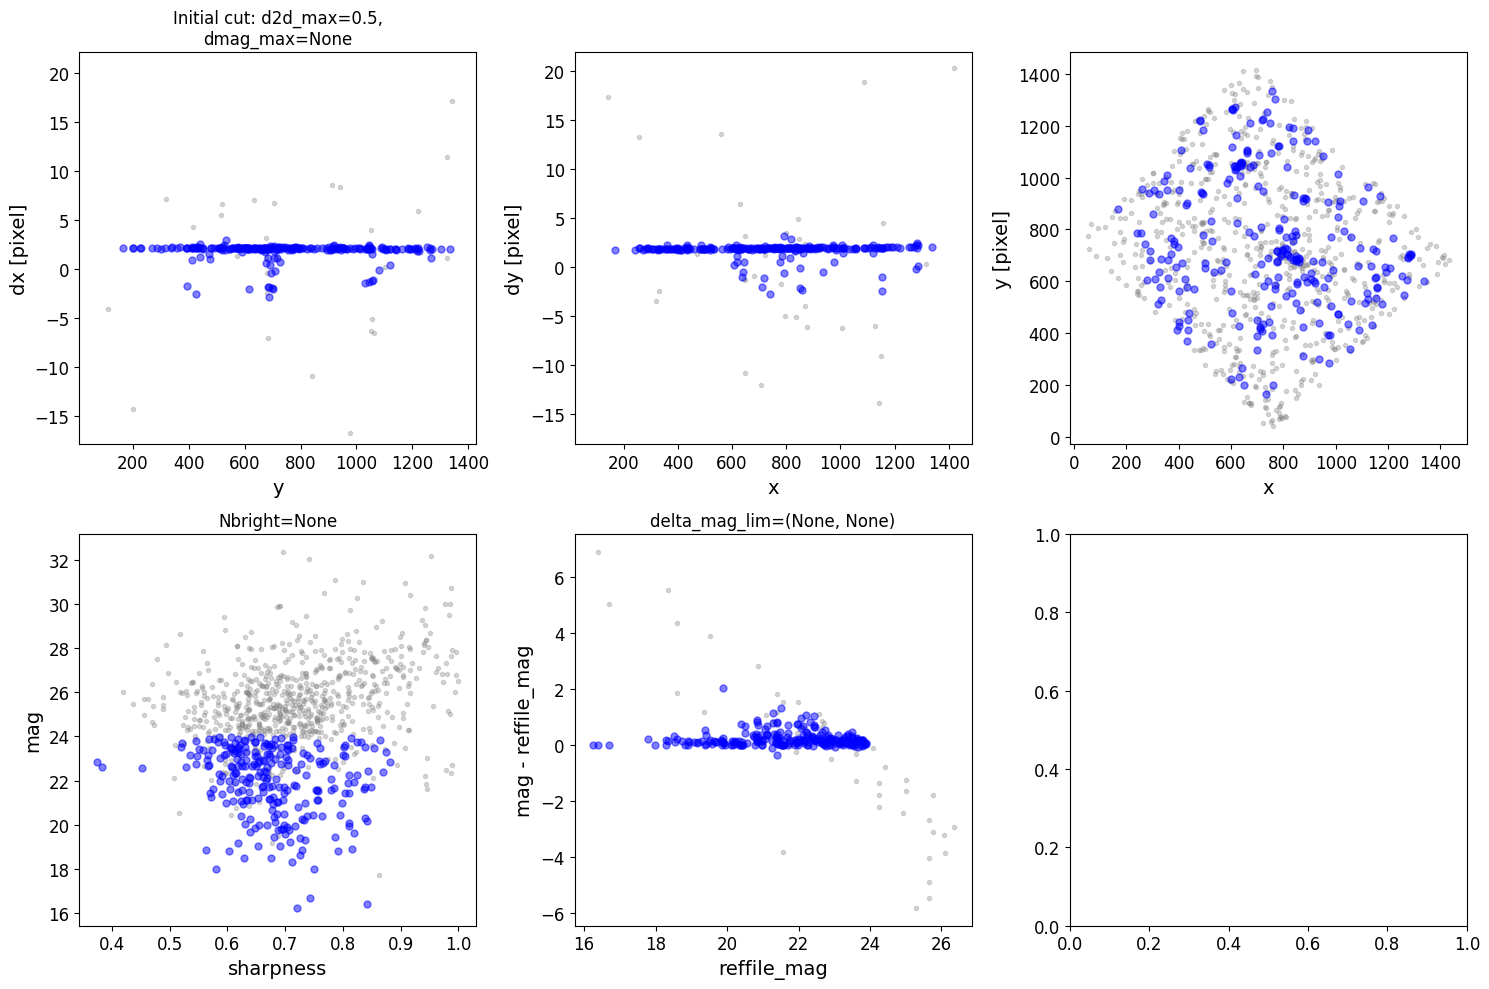

    slope  intercept     maxval  index  d_bestguess  fwhm  multimax
-0.000098   0.071191 183.673678     28     2.022576   0.8     False
Keeping 222 out of 222, skippin 0 because of null values in columns d_rot_tmp
median: 2.110833
75.000000 percentile cut: max residual for cut: 0.076543
median: 2.112779
i:00 mean:2.112779(0.002520) stdev:0.032375(0.001777) X2norm:1.00 Nchanged:0 Ngood:166 Nclip:56

mean: 2.114075
i:01 mean:2.114075(0.002887) stdev:0.038415(0.002036) X2norm:1.00 Nchanged:12 Ngood:178 Nclip:44

mean: 2.113588
i:02 mean:2.113588(0.003081) stdev:0.041561(0.002172) X2norm:1.00 Nchanged:5 Ngood:183 Nclip:39

mean: 2.113580
i:03 mean:2.113580(0.003189) stdev:0.043262(0.002249) X2norm:1.00 Nchanged:2 Ngood:185 Nclip:37

mean: 2.110885
i:04 mean:2.110885(0.003397) stdev:0.046577(0.002396) X2norm:1.00 Nchanged:4 Ngood:189 Nclip:33

mean: 2.111600
i:05 mean:2.111600(0.003454) stdev:0.047488(0.002436) X2norm:1.00 Nchanged:1 Ngood:190 Nclip:32

mean: 2.112334
i:06 mean:2.112334(0.0

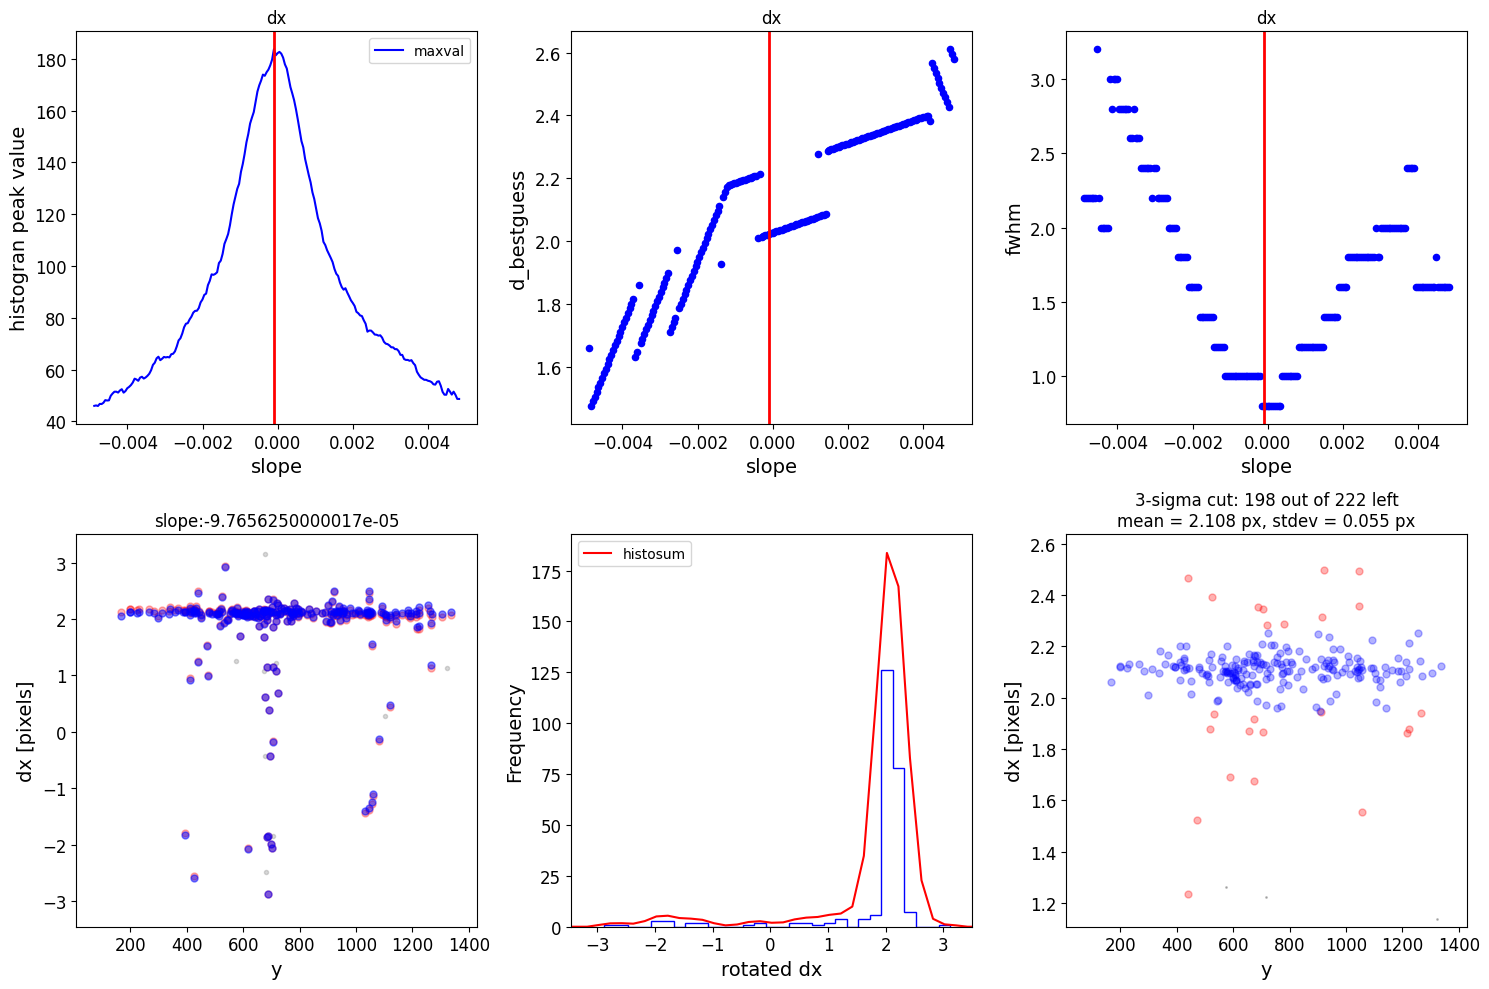

   slope  intercept    maxval  index  d_bestguess  fwhm  multimax
0.000146   -0.10686 185.08144      5     1.964436   0.8     False
Keeping 198 out of 198, skippin 0 because of null values in columns d_rot_tmp
median: 1.946136
75.000000 percentile cut: max residual for cut: 0.064640
median: 1.947841
i:00 mean:1.947841(0.002509) stdev:0.030420(0.001768) X2norm:1.00 Nchanged:0 Ngood:148 Nclip:50

mean: 1.939984
i:01 mean:1.939984(0.002941) stdev:0.037665(0.002073) X2norm:1.00 Nchanged:17 Ngood:165 Nclip:33

mean: 1.938798
i:02 mean:1.938798(0.003106) stdev:0.040264(0.002190) X2norm:1.00 Nchanged:4 Ngood:169 Nclip:29

mean: 1.937518
i:03 mean:1.937518(0.003415) stdev:0.045050(0.002408) X2norm:1.00 Nchanged:6 Ngood:175 Nclip:23

mean: 1.938289
i:04 mean:1.938289(0.003692) stdev:0.049402(0.002604) X2norm:1.00 Nchanged:5 Ngood:180 Nclip:18

mean: 1.939838
i:05 mean:1.939838(0.004048) stdev:0.055060(0.002855) X2norm:1.00 Nchanged:6 Ngood:186 Nclip:12

mean: 1.939851
i:06 mean:1.939851(0.00417

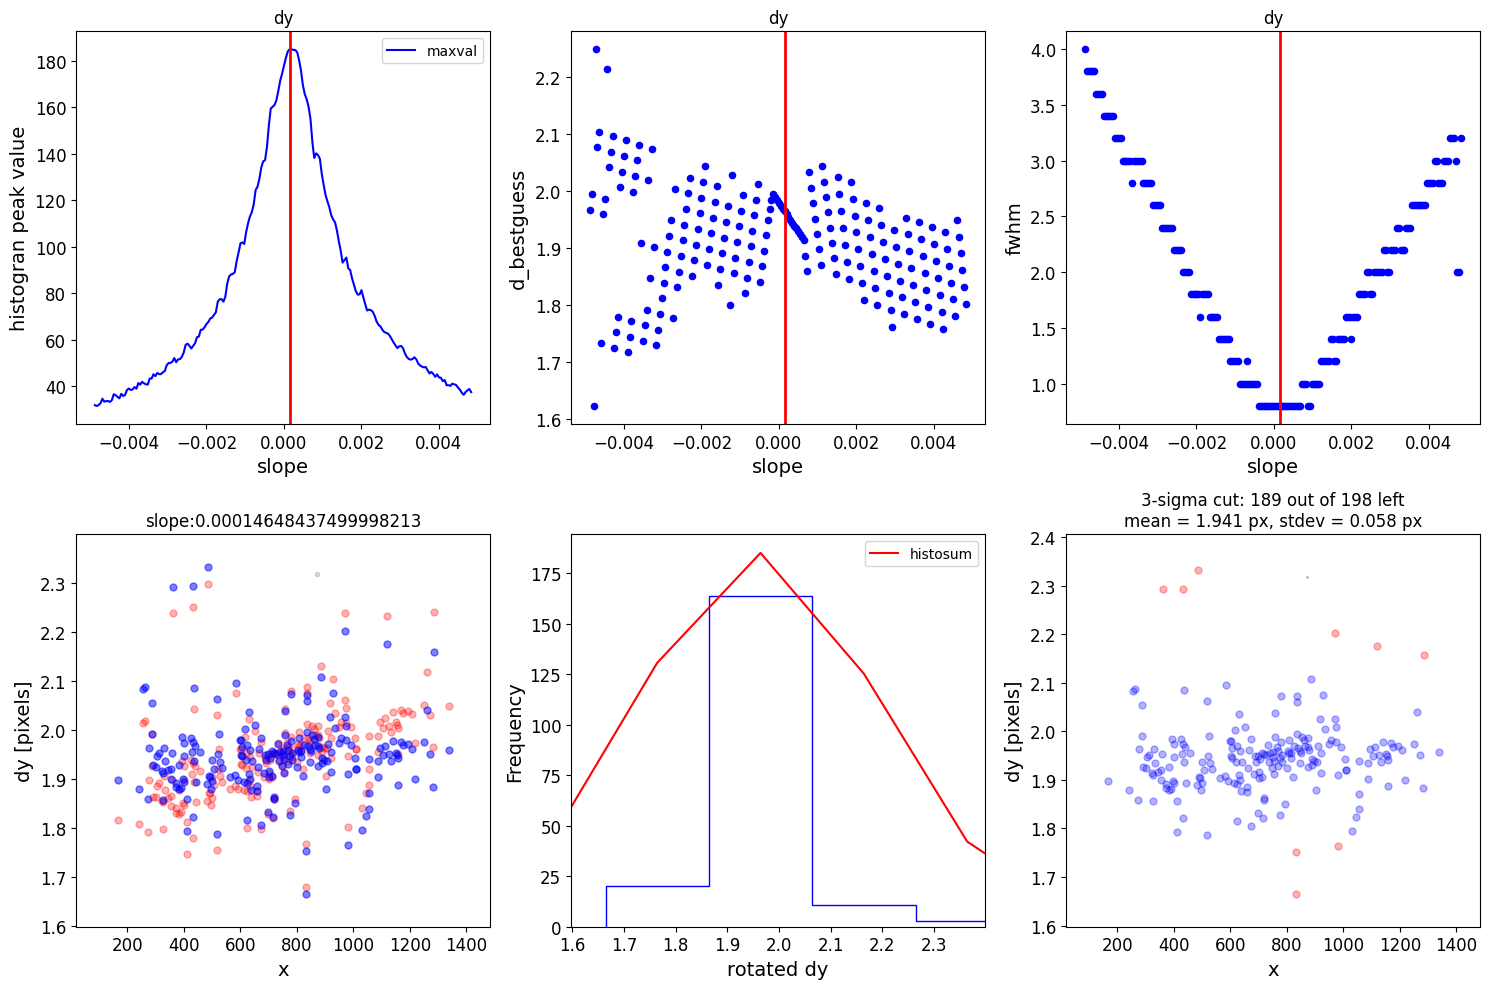

*** Note: close plots to continue!


<Figure size 640x480 with 0 Axes>

2023-01-02 10:07:03,777 - stpipe.TweakRegStep - INFO - TweakRegStep instance created.
2023-01-02 10:07:04,205 - stpipe.TweakRegStep - INFO - Step TweakRegStep running with args ([<ImageModel(1458, 1459) from hst_16264_12_wfc3_ir_f110w_iebc12_drz.fits>],).
2023-01-02 10:07:04,208 - stpipe.TweakRegStep - INFO - Step TweakRegStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/arest/nircam/jhat/notebooks/mastDownload/hst_16264_12_wfc3_ir_f110w_iebc12_tweakregstep.fits', 'output_dir': './mastDownload', 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.5, 'snr_threshold': 50, 'brightest': 4000, 'peakmax': None, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 4, 'searchrad': 0.5, 'use2dhist': True, 'separation': 9, 'tolerance': 0.7, 'xoffset': 0, 'yoffset': 0, 'fi

AttributeError: No attribute 'wcs'

In [7]:
wcs_align = st_wcs_align()


wcs_align.run_all(align_image,
		  telescope='hst',
		  outsubdir='mastDownload',
          refcat_racol='ra',
          refcat_deccol='dec',
          refcat_magcol='mag',
          refcat_magerrcol='dmag',
          overwrite=True,
          d2d_max=.5,
          showplots=2,
          refcatname=ref_catname,
          histocut_order='dxdy',
              sharpness_lim=(0.3,0.9),
              roundness1_lim=(-0.7, 0.7),
              SNR_min= 3,
              dmag_max=1.0,
              objmag_lim =(14,24))

**Check the Output**

The reference image has not changed, but let's read in the newly
aligned image and compare with the original. 
subsequent correction needed for optimal alignment.



In [ ]:
aligned_image = os.path.join('mastDownload',os.path.basename(align_image).replace('.fits','.jhat.fits'))
aligned_fits = fits.open(aligned_image)
aligned_data = fits.open(aligned_image)['SCI',1].data
aligned_y,aligned_x = skycoord_to_pixel(star_location,wcs.WCS(aligned_fits['SCI',1],aligned_fits))
aligned_cutout = extract_array(aligned_data,(11,11),(aligned_x,aligned_y))

norm3 = simple_norm(aligned_cutout,stretch='log',min_cut=-1,max_cut=200)
fig,axes = plt.subplots(1,3)
axes[0].imshow(ref_cutout, origin='lower',
                      norm=norm1,cmap='gray')
axes[1].imshow(align_cutout, origin='lower',
                      norm=norm2,cmap='gray')
axes[2].imshow(aligned_cutout, origin='lower',
                      norm=norm3,cmap='gray')
axes[0].set_title('Reference')
axes[1].set_title('To Align')
axes[2].set_title('Aligned')
for i in range(3):
	axes[i].tick_params(labelcolor='none',axis='both',color='none')


plt.show()

## Align to Gaia

You can also align each image to the Gaia DR3 catalog, or you
could replace the catalog created in step one with your own
catalog of the field. 



In [ ]:
wcs_align.run_all(align_image,
		  telescope='hst',
		  outsubdir='mastDownload',
          overwrite=True,
          d2d_max=.5,
          showplots=0,
          refcatname='Gaia',
          histocut_order='dxdy',
              sharpness_lim=(0.3,0.9),
              roundness1_lim=(-0.7, 0.7),
              SNR_min= 3,
              dmag_max=1.0,
              objmag_lim =(14,24))

aligned_image = os.path.join('mastDownload',os.path.basename(align_image).replace('.fits','.jhat.fits'))
aligned_fits = fits.open(aligned_image)
aligned_data = fits.open(aligned_image)['SCI',1].data
aligned_y,aligned_x = skycoord_to_pixel(star_location,wcs.WCS(aligned_fits['SCI',1],aligned_fits))
aligned_cutout = extract_array(aligned_data,(11,11),(aligned_x,aligned_y))

norm3 = simple_norm(aligned_cutout,stretch='log',min_cut=-1,max_cut=200)
fig,axes = plt.subplots(1,2)
axes[0].imshow(align_cutout, origin='lower',
                      norm=norm2,cmap='gray')
axes[1].imshow(aligned_cutout, origin='lower',
                      norm=norm3,cmap='gray')
axes[0].set_title('To Align')
axes[1].set_title('Aligned')
for i in range(2):
	axes[i].tick_params(labelcolor='none',axis='both',color='none')


plt.show()

## Large Offsets

Sometimes the initial images are so poorly aligned, that the code
fails. Here we read in the same image as in the first example,
and add an additional 3 pixel offset in the wcs. 



In [ ]:
files = glob.glob('mastDownload/HST/*/*drz.fits')
align_image = files[1]
align_fits = fits.open(align_image)
align_fits['SCI',1].header['CRPIX1']+=3
align_fits['SCI',1].header['CRPIX2']+=3
align_fits.writeto(align_image,overwrite=True)

align_data = fits.open(align_image)['SCI',1].data
ref_y,ref_x = skycoord_to_pixel(star_location,wcs.WCS(ref_fits['SCI',1],ref_fits))
align_y,align_x = skycoord_to_pixel(star_location,wcs.WCS(align_fits['SCI',1],align_fits))

ref_cutout = extract_array(ref_data,(11,11),(ref_x,ref_y))
align_cutout = extract_array(align_data,(11,11),(align_x,align_y))
norm1 = simple_norm(ref_cutout,stretch='log',min_cut=-1,max_cut=200)
norm2 = simple_norm(align_cutout,stretch='log',min_cut=-1,max_cut=200)
fig,axes = plt.subplots(1,2)
axes[0].imshow(ref_cutout, origin='lower',
                      norm=norm1,cmap='gray')
axes[1].imshow(align_cutout, origin='lower',
                      norm=norm2,cmap='gray')
axes[0].set_title('Reference')
axes[1].set_title('To Align')
axes[0].tick_params(labelcolor='none',axis='both',color='none')
axes[1].tick_params(labelcolor='none',axis='both',color='none')

plt.show()

wcs_align = st_wcs_align()

try:
	wcs_align.run_all(align_image,
		  telescope='hst',
		  outsubdir='mastDownload',
          refcat_racol='ra',
          refcat_deccol='dec',
          refcat_magcol='mag',
          refcat_magerrcol='dmag',
          overwrite=True,
          d2d_max=.5,
          showplots=2,
          refcatname=ref_catname,
          histocut_order='dxdy',
              sharpness_lim=(0.3,0.9),
              roundness1_lim=(-0.7, 0.7),
              SNR_min= 3,
              dmag_max=1.0,
              objmag_lim =(14,24))

except:
	print('Failed for not enough matches!')

This is what a failure looks like (compare to the plots above).
There are now a couple of options here. You can increase the 
d2d_max parameter, which increases the allowed distance between 
sources being matched in the reference and target images:



In [ ]:
wcs_align = st_wcs_align()


wcs_align.run_all(align_image,
		  telescope='hst',
		  outsubdir='mastDownload',
          refcat_racol='ra',
          refcat_deccol='dec',
          refcat_magcol='mag',
          refcat_magerrcol='dmag',
          overwrite=True,
          d2d_max=1,
          showplots=2,
          refcatname=ref_catname,
          histocut_order='dxdy',
              sharpness_lim=(0.3,0.9),
              roundness1_lim=(-0.7, 0.7),
              SNR_min= 3,
              dmag_max=1.0,
              objmag_lim =(14,24))

aligned_image = os.path.join('mastDownload',os.path.basename(align_image).replace('.fits','.jhat.fits'))
aligned_fits = fits.open(aligned_image)
aligned_data = fits.open(aligned_image)['SCI',1].data
aligned_y,aligned_x = skycoord_to_pixel(star_location,wcs.WCS(aligned_fits['SCI',1],aligned_fits))
aligned_cutout = extract_array(aligned_data,(11,11),(aligned_x,aligned_y))

norm3 = simple_norm(aligned_cutout,stretch='log',min_cut=-1,max_cut=200)
fig,axes = plt.subplots(1,3)
axes[0].imshow(ref_cutout, origin='lower',
                      norm=norm1,cmap='gray')
axes[1].imshow(align_cutout, origin='lower',
                      norm=norm2,cmap='gray')
axes[2].imshow(aligned_cutout, origin='lower',
                      norm=norm3,cmap='gray')
axes[0].set_title('Reference')
axes[1].set_title('To Align')
axes[2].set_title('Aligned')
for i in range(3):
	axes[i].tick_params(labelcolor='none',axis='both',color='none')


plt.show()

Or you can apply a rough guess for the offset, and then use a
smaller d2d_max for matching:



In [ ]:
wcs_align = st_wcs_align()


wcs_align.run_all(align_image,
		  telescope='hst',
		  outsubdir='mastDownload',
          refcat_racol='ra',
          refcat_deccol='dec',
          refcat_magcol='mag',
          refcat_magerrcol='dmag',
          overwrite=True,
          d2d_max=.25,
          xshift=5,
          yshift=5,
          showplots=2,
          refcatname=ref_catname,
          histocut_order='dxdy',
              sharpness_lim=(0.3,0.9),
              roundness1_lim=(-0.7, 0.7),
              SNR_min= 3,
              dmag_max=1.0,
              objmag_lim =(14,24))

aligned_image = os.path.join('mastDownload',os.path.basename(align_image).replace('.fits','.jhat.fits'))
aligned_fits = fits.open(aligned_image)
aligned_data = fits.open(aligned_image)['SCI',1].data
aligned_y,aligned_x = skycoord_to_pixel(star_location,wcs.WCS(aligned_fits['SCI',1],aligned_fits))
aligned_cutout = extract_array(aligned_data,(11,11),(aligned_x,aligned_y))

norm3 = simple_norm(aligned_cutout,stretch='log',min_cut=-1,max_cut=200)
fig,axes = plt.subplots(1,3)
axes[0].imshow(ref_cutout, origin='lower',
                      norm=norm1,cmap='gray')
axes[1].imshow(align_cutout, origin='lower',
                      norm=norm2,cmap='gray')
axes[2].imshow(aligned_cutout, origin='lower',
                      norm=norm3,cmap='gray')
axes[0].set_title('Reference')
axes[1].set_title('To Align')
axes[2].set_title('Aligned')
for i in range(3):
	axes[i].tick_params(labelcolor='none',axis='both',color='none')


plt.show()